Load libraries.

In [1]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Statistical analysis libraries
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

# SQLite capability libraries
import sqlite3
from sqlite3 import Error

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Function: create connection to SQLite databas

In [2]:
def createConnection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error:
        print(Error)
    return conn

Function: connect to SQLite database

In [3]:
def sqlConnect():
    try:
        conn = sqlite3.connect(':memory:')
        print('Connection is established: Database is created in memory')
    except Error:
        print(Error)
    return conn

Function: insert a row of historical stock data in the SQLite table

In [4]:
def sqlInsert(conn, entities):
    cursor = con.cursor()
    cursor.execute('INSERT INTO stocks(ticker, avg_annual_return,'
                   'annual_volatility, skew, kurtosis) VALUES(?,?,?,?,?)',
                   entities)
    con.commit()
    return

Compute statistical measures (standard deviation, skew, kurtosis) for each stock

In [5]:
def stockAnalysis(ticker):
    tickerFile = ticker + '.csv'
    data = pd.read_csv(tickerFile, parse_dates=['Date'])
    data = data.sort_values(by='Date')
    data.set_index('Date', inplace=True)

    data['Returns'] = data['Adj Close'].pct_change()  # create a column of daily returns
    returns = data['Returns'].dropna()  # remove entries with N/A data

    # Statistical stock data based on daily returns
    avgDailyReturn = np.mean(returns)
    avgAnnualReturn = ((1 + avgDailyReturn) ** 252) - 1
    stdDev = np.std(returns)
    annualVolatility = stdDev * np.sqrt(252)
    stockSkew = skew(returns)
    stockKurtosis = kurtosis(returns)

    stockRetMat[ticker] = returns

    # Stock data to be inserted into database table
    dataEntry = (ticker, avgAnnualReturn, annualVolatility, stockSkew,
                 stockKurtosis)

    return dataEntry

List tickers of securities in portfolio

In [6]:
stockPort = ['AAPL', 'AMZN', 'FB', 'GE', 'JPM', 'MSFT', 'TSLA', 'V']

Connect to SQLite database

In [7]:
con = createConnection('mydatabase.db')
cursor = con.cursor()
sqlConnect()

Connection is established: Database is created in memory


Create SQLite table

In [8]:
cursor.execute('CREATE TABLE stocks(ticker text PRIMARY KEY,'
               'avg_annual_return real, annual_volatility real, skew real,'
               'kurtosis real)')
con.commit()

Create empty dataframe of daily stock returns matrix

In [9]:
stockRetMat = pd.DataFrame(columns=stockPort)

For every stock ticker in portfolio, perform stock analysis and load the results in the SQLite table

In [10]:
for stock in stockPort:
    stockData = stockAnalysis(stock)
    sqlInsert(con, stockData)

Generate a correlation matrix of the stock returns using the Pearson method

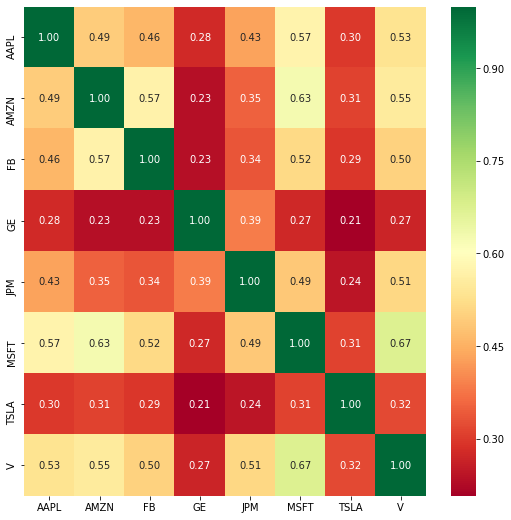

In [11]:
corrMatrix = stockRetMat.corr(method='pearson')
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(data=corrMatrix,
            cmap='RdYlGn',
            annot=True,
            fmt='.2f'
            )
plt.show()

Print all rows in the SQLite table

In [12]:
cursor.execute('SELECT * FROM stocks')
rows = cursor.fetchall()
for row in rows:
    print(row)

('AAPL', 0.2843880091605899, 0.2483687196253576, -0.23895112411169017, 3.794429660323237)
('AMZN', 0.5009879901932761, 0.2924922411616182, 1.0226246758258493, 9.88184992627834)
('FB', 0.26755699483296813, 0.2821226282079576, -0.4299825567330655, 17.247869660387376)
('GE', -0.06376913129104889, 0.2996679502686821, 0.4412057257955848, 6.560879702066153)
('JPM', 0.23539347321334425, 0.20987925788838374, 0.03533003592922064, 3.1822813202553366)
('MSFT', 0.3442696484246921, 0.2330742360552858, 0.28831241784631756, 7.121003829179983)
('TSLA', 0.2655243826669329, 0.4492485748297106, 0.28941197240031374, 5.125252079527762)
('V', 0.27310613337615064, 0.20406985900356883, -0.007403278531559054, 3.3742718248537162)
